# Time series forecasting with Prophet

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
path = "../../../data/statsmodels/AirPassengers.parquet"

In [3]:
import pandas as pd

df = pd.read_parquet(path).asfreq('ME')
df.columns = ['values']

series = df['values']
series

1949-01-31    112
1949-02-28    118
             ... 
1960-11-30    390
1960-12-31    432
Freq: ME, Name: values, Length: 144, dtype: int64

## Prepare DataFrame for Prophet

In [4]:
df = pd.DataFrame({
    'ds': series.index,
    'y': series.values
}, index=series.index)

## Model fit

In [5]:
start, end = series.index.year.unique()[[0, -1]]

In [6]:
end = end + 10

In [7]:
yl = list(range (start, end))

In [8]:
from prophet.make_holidays import make_holidays_df

holidays = make_holidays_df(year_list=yl, country='US')

In [9]:
from prophet import Prophet

model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    holidays=holidays
)

model.params

{}

In [10]:
model.fit(df)

11:44:01 - cmdstanpy - INFO - Chain [1] start processing
11:44:02 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
model.params

OrderedDict([('lp__', array([[504.34]])),
             ('k', array([[0.390075]])),
             ('m', array([[0.185295]])),
             ('delta',
              array([[ 4.48760e-09,  2.89890e-08,  3.05688e-03,  9.28836e-02,
                       2.08025e-04,  5.26127e-05,  2.32313e-08, -8.51108e-10,
                       4.91605e-09,  2.42685e-10,  2.43319e-09, -9.17936e-09,
                       3.44694e-09,  1.53073e-01,  1.31406e-01, -8.52206e-09,
                       1.00254e-09, -4.14816e-08, -6.90245e-03, -5.20129e-02,
                      -7.03300e-02, -4.86061e-02, -5.43384e-09,  9.55946e-09,
                       2.17210e-01]])),
             ('sigma_obs', array([[0.0165048]])),
             ('beta',
              array([[-0.0625118 , -0.155015  ,  0.0957688 ,  0.035435  , -0.071567  ,
                      -0.00088001, -0.0434363 , -0.0215201 , -0.0068293 ,  0.0924452 ,
                       0.120553  ,  0.0321282 ,  0.0164879 , -0.0931561 , -0.0708692 ,
            

In [12]:
pred = model.predict(df)

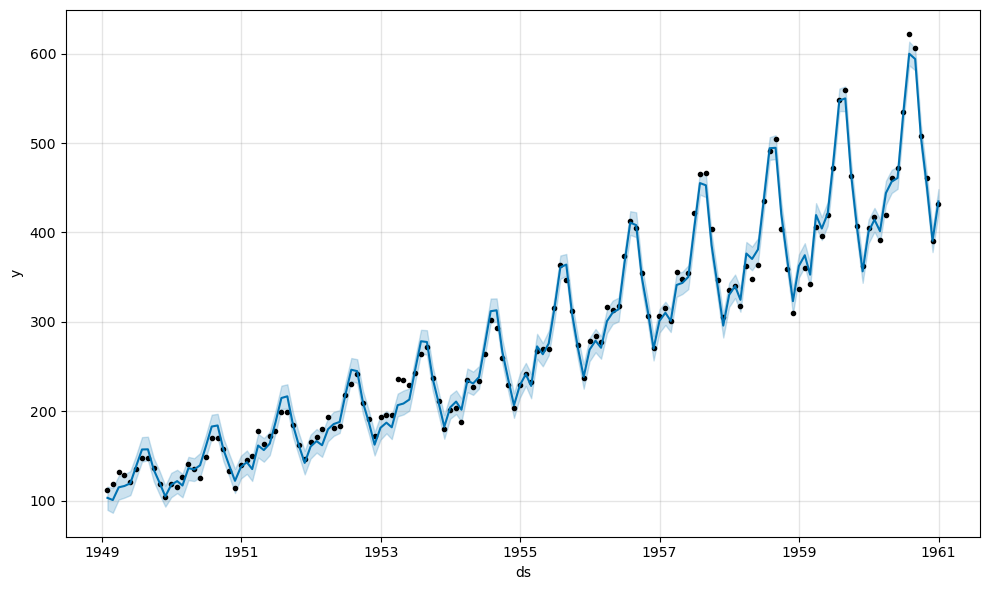

In [13]:
model.plot(pred);

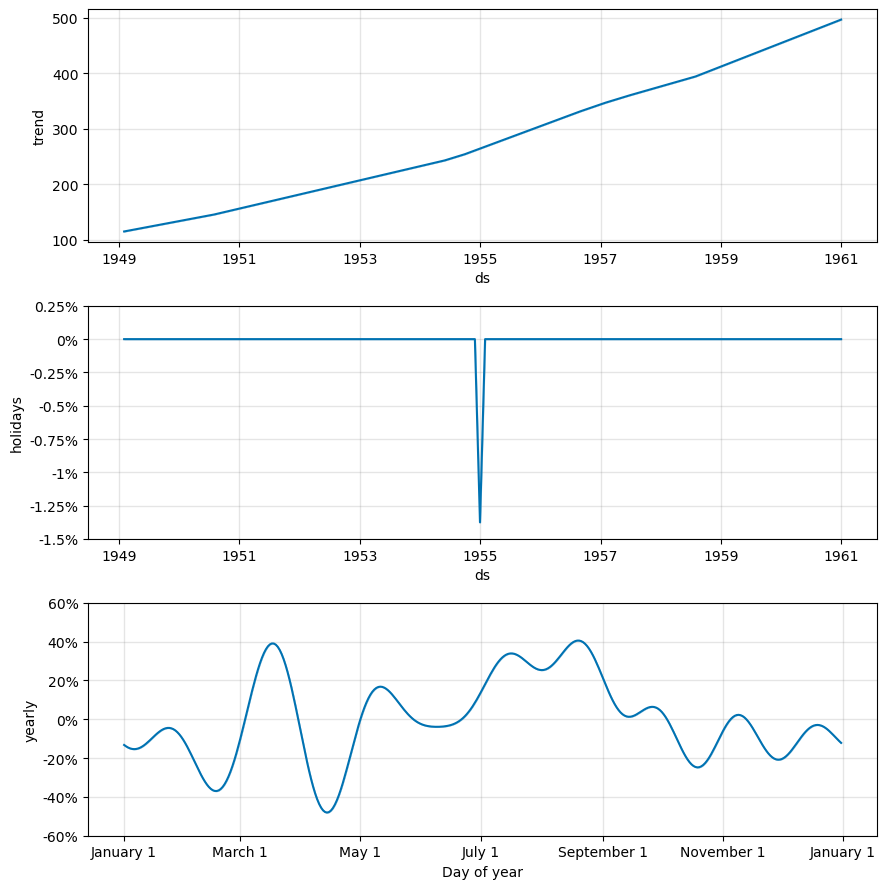

In [14]:
model.plot_components(pred);

## Forecast

In [15]:
future = model.make_future_dataframe(periods=48, freq='ME', include_history=True)

In [16]:
df_forecast = model.predict(future)

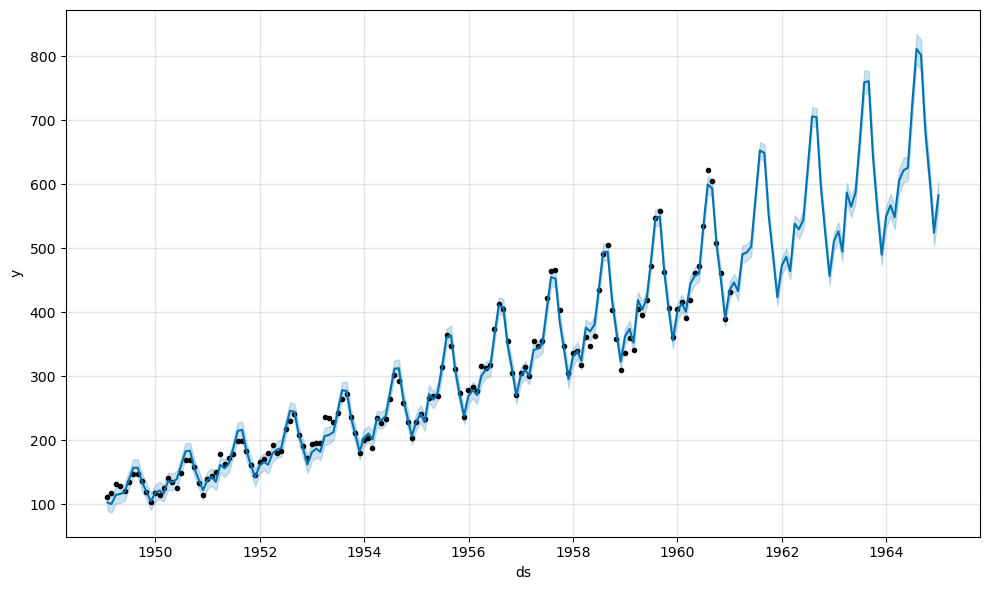

In [17]:
model.plot(df_forecast);

In [18]:
utils.plot_prophet_forecast(df['y'], df_forecast)

## Configuration

1. Prophet automatically detects trend and seasonality using changepoints.
2. You configure:

   * **Trend flexibility** (with or without change points)
   * **Additive vs. multiplicative** seasonality (`seasonality_mode`)
   * **Custom seasonalities** (optional)
   * **Holiday effects** (optional)


**📌 Rule of Thumb**

> “Prophet config is semi-automatic: trend and seasonal components are learned with flexible change points. You choose seasonal mode and horizon — minimal tuning required.”



**Seasonal decomposition visual insight only.**

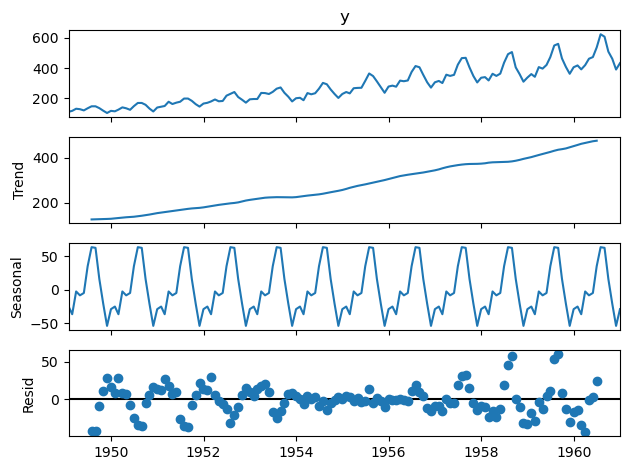

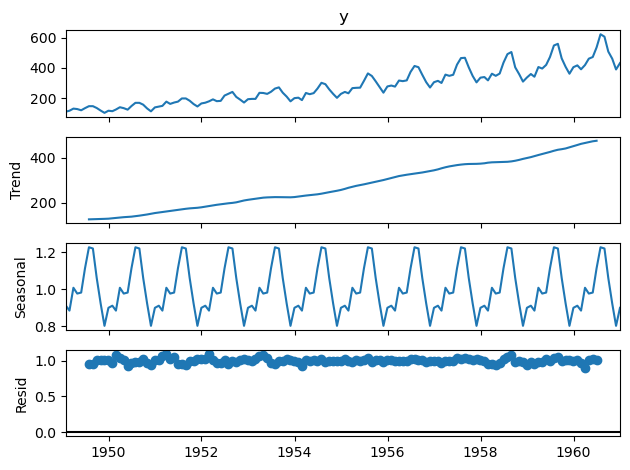

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['y'], model="additive", period=12).plot();
seasonal_decompose(df['y'], model="multiplicative", period=12).plot();

## Variation playground

### Prophet

In [20]:
from modules import utils

df = series.to_frame()

df = utils.get_model_forecast_prophet(df, column="values", mode="additive")
df = utils.get_model_forecast_prophet(df, column="values", mode="multiplicative")

df

11:44:02 - cmdstanpy - INFO - Chain [1] start processing
11:44:02 - cmdstanpy - INFO - Chain [1] done processing
11:44:02 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing


,values,prophet_additive,prophet_multiplicative
1949-01-31,112.0,NaN,NaN
1949-02-28,118.0,NaN,NaN
...,...,...,...
1964-11-30,NaN,568.963094,525.884549
1964-12-31,NaN,597.874859,583.970836


In [21]:
df.plot()

### SARIMA vs Exponential Smoothing vs Prophet

In [22]:
import numpy as np

df = series.to_frame()
df["values_log"] = np.log(df["values"])

df_forecast = utils.get_model_forecast(
    df, "values_log", order=(12, 1, 1), horizon=96, forecast_exp=True
)
df_forecast = utils.get_model_forecast(
    df_forecast,
    "values_log",
    order=(0, 1, 1),
    seasonal_order=(0, 1, 1, 12),
    horizon=96,
    forecast_exp=True,
)
df_forecast = utils.get_model_forecast_exponential_smoothing(
    df_forecast,
    "values",
    horizon=96,
    class_config={"trend": "add", "seasonal": "mul", "seasonal_periods": 12},
)
df_forecast = utils.get_model_forecast_prophet(
    df_forecast, "values", mode="multiplicative", horizon=96, yearly_seasonality=True
)

df_forecast = df_forecast.drop(columns=["values_log"])
df_forecast.plot(color="variable")

/Users/sota/miniforge3/envs/work/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

11:44:03 - cmdstanpy - INFO - Chain [1] start processing
11:44:03 - cmdstanpy - INFO - Chain [1] done processing


## Diagnostics and assumptions

Although Prophet is robust and doesn’t require stationarity or normal residuals, residual analysis helps confirm quality.

### Residual calculation

In [11]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=holidays,
    seasonality_mode="multiplicative",
)

model.fit(df)

forecast = model.predict(df)

df_forecast = forecast.set_index("ds")[["yhat"]].join(df.set_index("ds"))
df_forecast["residuals"] = df_forecast["y"] - df_forecast["yhat"]

residuals = df_forecast["residuals"].dropna()
residuals

ds
1949-01-31     9.102743
1949-02-28    17.532820
                ...    
1960-11-30    -0.823304
1960-12-31    -2.804351
Name: residuals, Length: 144, dtype: float64

### Autocorrelation

#### Plot

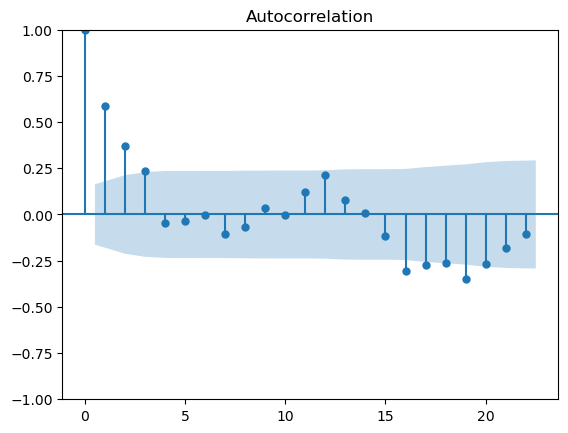

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

#### Test: Ljung-Box

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,82.668229,0.000000
20,167.529442,0.000000
30,219.288026,0.000000


### Normality

#### Plot

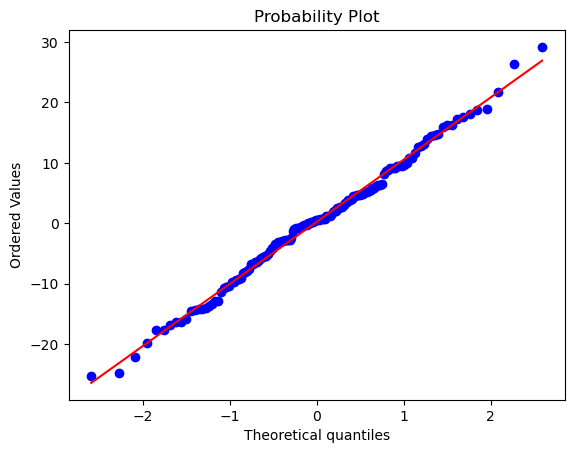

In [14]:
from scipy import stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

#### Test: Jarque-Bera

In [15]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(0.018871983201470002), pvalue=np.float64(0.9906083876708386))

### Homoscedasticity

#### Plot

In [16]:
residuals.plot()

#### Test

In [17]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(16.596914206299374),
 np.float64(0.08377279981299146),
 1.7388132803953582,
 0.0793106680683477)